In [1]:
import os
import nltk
import re
import spacy
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from enum import Enum
from typing import Union
from spacy.tokens import Token
from gensim.models import KeyedVectors

from sklearn import metrics
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# Loading the data


In [2]:
TRAIN_PATH = os.path.join(os.getcwd(), "data", "train.csv")


Let's rename the columns to make them easier to work with.


In [3]:
data_df = pd.read_csv(TRAIN_PATH, index_col="index")
data_df = data_df.rename(
    columns={
        "tweet": "text",
        "prejudice_woman": "woman",
        "prejudice_lgbtiq": "lgbtiq",
        "prejudice_inmigrant_race": "race",
        "mean_prejudice": "mean",
    }
)

data_df = data_df.sort_index()

display(data_df.head(5))
display(data_df.describe())

,text,humor,woman,lgbtiq,race,gordofobia,mean
index,,,,,,,
9,MENTION Ya estará colocada en algún chiringuit...,0,1,0,0,0,3.4
22,"Sin querer, hoy le dije “Hola” a una feminista...",1,1,0,0,0,3.8
30,"En este capítulo, que se transmitió en el Cana...",0,0,1,0,0,2.2
40,MENTION MENTION MENTION Concuerdo contigo en e...,0,0,1,0,0,3.8
45,– ¡No es no! ¡En mi cuerpo mando yo!\r\n– ¡Así...,1,1,0,0,0,2.2


,humor,woman,lgbtiq,race,gordofobia,mean
count,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000
mean,0.325346,0.483714,0.227256,0.248596,0.080120,3.053126
std,0.468592,0.499828,0.419138,0.432280,0.271529,0.809173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.400000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,3.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


Let's load the spacy model


In [4]:
SPACY_MODEL = "es_core_news_lg"
# TODO: Try other spanish spacy models: es_core_news_md, es_core_news_lg, es_dep_news_trf

try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


By using the default pipeline of the spacy model, we can get tokens with information about their part of speech, lemma, whether they are a stop word, etc.


In [5]:
# Tokenize text
parsed_df = data_df.copy()
parsed_df["tokens"] = list(nlp.pipe(parsed_df["text"]))
parsed_df["tokens"] = parsed_df["tokens"].apply(lambda x: [token for token in x])
display(parsed_df.head(5))


,text,humor,woman,lgbtiq,race,gordofobia,mean,tokens
index,,,,,,,,
9,MENTION Ya estará colocada en algún chiringuit...,0,1,0,0,0,3.4,"[MENTION, Ya, estará, colocada, en, algún, chi..."
22,"Sin querer, hoy le dije “Hola” a una feminista...",1,1,0,0,0,3.8,"[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,..."
30,"En este capítulo, que se transmitió en el Cana...",0,0,1,0,0,2.2,"[En, este, capítulo, ,, que, se, transmitió, e..."
40,MENTION MENTION MENTION Concuerdo contigo en e...,0,0,1,0,0,3.8,"[MENTION, MENTION, MENTION, Concuerdo, contigo..."
45,– ¡No es no! ¡En mi cuerpo mando yo!\r\n– ¡Así...,1,1,0,0,0,2.2,"[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando..."


In [6]:
# Show some data about a token
token: Token = parsed_df["tokens"].iloc[0][5]
print("Text: ", token.text)
print("Lemma: ", token.lemma_)
print("POS: ", token.pos_)
print("Tag: ", token.tag_)
print("Dep: ", token.dep_)
print("Shape: ", token.shape_)
print("Is alpha: ", token.is_alpha)
print("Is stop: ", token.is_stop)


Text:  algún
Lemma:  alguno
POS:  DET
Tag:  DET
Dep:  det
Shape:  xxxx
Is alpha:  True
Is stop:  True


## Token filtering utility

Let's create utility functions to filter the tokens based on their attributes. We can easily use these functions to filter the tokens, build and experiment with different representations of the data in the next steps of the project.


In [7]:
EMOJI_PATTERN = re.compile(
    "["
    + "\U0001F600-\U0001F64F"
    + "\U0001F300-\U0001F5FF"
    + "\U0001F680-\U0001F6FF"
    + "\U0001F1E0-\U0001F1FF"
    + "\U00002500-\U00002BEF"
    + "\U00002702-\U000027B0"
    + "\U00002702-\U000027B0"
    + "\U000024C2-\U0001F251"
    + "\U0001f926-\U0001f937"
    + "\U00010000-\U0010ffff"
    + "\u2640-\u2642"
    + "\u2600-\u2B55"
    + "\u200d"
    + "\u23cf"
    + "\u23e9"
    + "\u231a"
    + "\ufe0f"
    + "\u3030"
    + "]+",
    flags=re.UNICODE,
)

try:
    STOPWORDS = nltk.corpus.stopwords.words("spanish")
except LookupError:
    nltk.download("stopwords")
    STOPWORDS = nltk.corpus.stopwords.words("spanish")

In [8]:
FILTER_FUNC = {
    "punct": lambda token: token.is_punct,
    "stopwords": lambda token: token.text.lower() in STOPWORDS,
    "emoji": lambda token: EMOJI_PATTERN.match(token.text),
    "number": lambda token: token.like_num,
    "newline": lambda token: re.match(r"\n+", token.text),
    "space": lambda token: token.is_space and not re.match(r"\n+", token.text),
    "tags": lambda token: token.text in ["MENTION", "HASHTAG", "URL"],
}


class Filter(Enum):
    PUNCT = "punct"
    STOPWORDS = "stopwords"
    EMOJI = "emoji"
    NUMBER = "number"
    NEWLINE = "newline"
    SPACE = "space"
    TAGS = "tags"


def filter_tokens(series: pd.Series, filters: list[Filter]) -> pd.Series:
    """
    Filters a series of tokens using the given filters.
    args:
        series: a series of lists of tokens
        filters: a list of filters to apply
    returns:
        a series of lists of tokens
    """
    return series.apply(
        lambda tokens: [
            token
            for token in tokens
            if not any([FILTER_FUNC[filter.value](token) for filter in filters])
        ]
    )

In [9]:
def test_filter_tokens(result, expected):
    error = False
    for token, expected_token in zip(result, expected):
        try:
            assert token.text == expected_token
        except AssertionError:
            print(f"Expected: '{expected_token}', got: '{token.text}'")
            error = True

    if not error:
        print("Test passed!")


# test Filter.PUNCT
result = filter_tokens(parsed_df["tokens"], [Filter.PUNCT]).loc[22]
expected = [
    "Sin",
    "querer",
    "hoy",
    "le",
    "dije",
    "Hola",
    "a",
    "una",
    "feminista",
    "El",
    "juicio",
    "es",
    "mañana",
    "\n\n",
    "HASHTAG",
    "   ",
    "feminismo",
    "  ",
]
test_filter_tokens(result, expected)

# test Filter.STOPWORDS
result = filter_tokens(parsed_df["tokens"], [Filter.STOPWORDS]).loc[9]
expected = ["MENTION", "colocada", "algún", "chiringuito", "feminazi"]
test_filter_tokens(result, expected)

# test Filter.EMOJI
result = filter_tokens(parsed_df["tokens"], [Filter.EMOJI]).loc[75]
expected = ["Demasiadas", "mujeres", ",", "demasiadas", "mujeres", "\n", "URL"]
test_filter_tokens(result, expected)

# test Filter.NUMBER
result = filter_tokens(parsed_df["tokens"], [Filter.NUMBER]).loc[5245]
expected = [
    "Acá",
    "te",
    "lo",
    "aclaro",
    ":",
    "\n",
    "de",
    "octubre",
    ":",
    "Día",
    "de",
    "brujas",
    "(",
    "Mujeres",
    ")",
    "\n",
    "de",
    "noviembre",
    ":",
    "Día",
    "de",
    "todos",
    "los",
    "santos",
    "(",
    "Hombres",
    ")",
    "\n",
    "noviembre",
    ":",
    "Día",
    "de",
    "los",
    "difuntos",
    "(",
    "Hombres",
    "que",
    "se",
    "animaron",
    "a",
    "decirle",
    "brujas",
    "a",
    "las",
    "mujeres",
    ")",
]
test_filter_tokens(result, expected)

# test Filter.NEWLINE
result = filter_tokens(parsed_df["tokens"], [Filter.NEWLINE]).loc[22]
expected = [
    "Sin",
    "querer",
    ",",
    "hoy",
    "le",
    "dije",
    "“",
    "Hola",
    "”",
    "a",
    "una",
    "feminista",
    ".",
    "El",
    "juicio",
    "es",
    "mañana",
    ".",
    "HASHTAG",
    "   ",
    "feminismo",
    "  ",
    "#",
]
test_filter_tokens(result, expected)

# test Filter.SPACE
result = filter_tokens(parsed_df["tokens"], [Filter.SPACE]).loc[22]
expected = [
    "Sin",
    "querer",
    ",",
    "hoy",
    "le",
    "dije",
    "“",
    "Hola",
    "”",
    "a",
    "una",
    "feminista",
    ".",
    "El",
    "juicio",
    "es",
    "mañana",
    ".",
    "\n\n",
    "HASHTAG",
    "feminismo",
    "#",
]

# test Filter.TAGS
result = filter_tokens(parsed_df["tokens"], [Filter.TAGS]).loc[14869]
# FIXME: Notice that when there is no space between `-` and the next word, both are recognized as a single token
expected = [
    "  ",
    "  ",
    "  \n",
    "-Te",
    "cuento",
    "un",
    "chiste",
    "machista",
    "?",
    "\n",
    "-Pero",
    "que",
    "dices",
    ",",
    "si",
    "soy",
    "mujer",
    ".",
    "\n",
    "-Tranquila",
    ",",
    "te",
    "lo",
    "explico",
    ".",
]
test_filter_tokens(result, expected)


# test all
result = filter_tokens(
    parsed_df["tokens"],
    [
        Filter.PUNCT,
        Filter.STOPWORDS,
        Filter.EMOJI,
        Filter.NUMBER,
        Filter.NEWLINE,
        Filter.SPACE,
    ],
).loc[5245]
expected = [
    "Acá",
    "aclaro",
    "octubre",
    "Día",
    "brujas",
    "Mujeres",
    "noviembre",
    "Día",
    "santos",
    "Hombres",
    "noviembre",
    "Día",
    "difuntos",
    "Hombres",
    "animaron",
    "decirle",
    "brujas",
    "mujeres",
]
test_filter_tokens(result, expected)

Expected: '

', got: '

'
Test passed!
Expected: '
', got: '
'
Expected: '
', got: '
'
Expected: '
', got: '
'
Expected: '
', got: '
'
Expected: 'HASHTAG', got: '

'
Expected: '   ', got: 'HASHTAG'
Expected: 'feminismo', got: '   '
Expected: '  ', got: 'feminismo'
Expected: '#', got: '  '
Expected: '  
', got: '  
'
Expected: '
', got: '
'
Expected: '
', got: '
'
Test passed!


# Representation of the data

## TF-IDF

TODO: Try different token filtering options for TF-IDF


In [10]:
# Remove stopwords, punctuations, emojis, numbers, newlines and spaces
tf_idf_df = parsed_df.copy()
tf_idf_df["processed"] = filter_tokens(
    tf_idf_df["tokens"],
    [
        Filter.PUNCT,
        Filter.STOPWORDS,
        Filter.EMOJI,
        Filter.NUMBER,
        Filter.NEWLINE,
        Filter.SPACE,
    ],
)

# Use lemmas instead of tokens
tf_idf_df["processed"] = tf_idf_df["processed"].apply(
    lambda tokens: [token.lemma_ for token in tokens]
)

# Concat all tokens into a single string
# This is needed for the TF-IDF vectorizer
tf_idf_df["processed"] = tf_idf_df["processed"].apply(lambda tokens: " ".join(tokens))

# lowercase
tf_idf_df["processed"] = tf_idf_df["processed"].apply(lambda tokens: tokens.lower())

# TF-IDF vectorizer
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_df["representation"] = (
    tf_idf_vectorizer.fit_transform(tf_idf_df["processed"]).toarray().tolist()
)

display(tf_idf_df.head())

,text,humor,woman,lgbtiq,race,gordofobia,mean,tokens,processed,representation
index,,,,,,,,,,
9,MENTION Ya estará colocada en algún chiringuit...,0,1,0,0,0,3.4,"[MENTION, Ya, estará, colocada, en, algún, chi...",mention colocado alguno chiringuito feminazi,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22,"Sin querer, hoy le dije “Hola” a una feminista...",1,1,0,0,0,3.8,"[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,...",querer hoy decir hola feminista juicio mañana ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
30,"En este capítulo, que se transmitió en el Cana...",0,0,1,0,0,2.2,"[En, este, capítulo, ,, que, se, transmitió, e...",capítulo transmitir canal televisión británico...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
40,MENTION MENTION MENTION Concuerdo contigo en e...,0,0,1,0,0,3.8,"[MENTION, MENTION, MENTION, Concuerdo, contigo...",mention mention mention concuerdo contigo supe...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
45,– ¡No es no! ¡En mi cuerpo mando yo!\r\n– ¡Así...,1,1,0,0,0,2.2,"[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando...",cuerpo mando así hablar empoderada poder abort...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
print(f"Length of tf-idf vector: {len(tf_idf_df['representation'].iloc[0])}")

Length of tf-idf vector: 7462


## Word embeddings

### FastText Spanish Unannotated Corpora

Pre-trained word embeddings were downloaded from [dccuchile/spanish-word-embeddings](https://github.com/dccuchile/spanish-word-embeddings#fasttext-embeddings-from-suc).

According to [josecannete/spanish-corpora](https://github.com/josecannete/spanish-corpora) the corpus on which the FastText embeddings were trained was processed in the following way:

> - Lowercase
> - Removed urls
> - Removed listing
> - Replaced multiple spaces with single one

so in order to get the best results we will need to do the same. Urls in the training set are replaced with the string `URL` but we will remove them anyway. We will do the same for hashtags and mentions.


In [12]:
fast_text_suc_df = parsed_df.copy()
fast_text_suc_df["processed"] = filter_tokens(
    fast_text_suc_df["tokens"], [Filter.SPACE, Filter.TAGS, Filter.NEWLINE]
)
fast_text_suc_df["processed"] = fast_text_suc_df["processed"].apply(
    lambda tokens: [token.text for token in tokens]
)

fast_text_suc_df.head()

,text,humor,woman,lgbtiq,race,gordofobia,mean,tokens,processed
index,,,,,,,,,
9,MENTION Ya estará colocada en algún chiringuit...,0,1,0,0,0,3.4,"[MENTION, Ya, estará, colocada, en, algún, chi...","[Ya, estará, colocada, en, algún, chiringuito,..."
22,"Sin querer, hoy le dije “Hola” a una feminista...",1,1,0,0,0,3.8,"[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,...","[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,..."
30,"En este capítulo, que se transmitió en el Cana...",0,0,1,0,0,2.2,"[En, este, capítulo, ,, que, se, transmitió, e...","[En, este, capítulo, ,, que, se, transmitió, e..."
40,MENTION MENTION MENTION Concuerdo contigo en e...,0,0,1,0,0,3.8,"[MENTION, MENTION, MENTION, Concuerdo, contigo...","[Concuerdo, contigo, en, eso, ,, super, repugn..."
45,– ¡No es no! ¡En mi cuerpo mando yo!\r\n– ¡Así...,1,1,0,0,0,2.2,"[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando...","[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando..."


In [13]:
# Load FastText model
FAST_TEXT_SUC_PATH = os.path.join(
    os.getcwd(), "embeddings", "fasttext", "embeddings-l-model.vec"
)
fast_text_suc_model = KeyedVectors.load_word2vec_format(FAST_TEXT_SUC_PATH)

In [14]:
fast_text_suc_vec_len = len(fast_text_suc_model["hola"])
print(fast_text_suc_vec_len)


300


In [15]:
# Represent each sentence as the average of its word embeddings
def get_sentence_embedding(tokens: list[str], model):
    embeddings = []
    at_least_one = False
    for token in tokens:
        try:
            embeddings.append(model[token])
            at_least_one = True
        except KeyError:
            pass

    if not at_least_one:
        return np.zeros(fast_text_suc_vec_len)

    return np.mean(embeddings, axis=0)


In [16]:
fast_text_suc_df["representation"] = fast_text_suc_df["processed"].apply(
    lambda tokens: get_sentence_embedding(tokens, fast_text_suc_model)
)
display(fast_text_suc_df.head())

,text,humor,woman,lgbtiq,race,gordofobia,mean,tokens,processed,representation
index,,,,,,,,,,
9,MENTION Ya estará colocada en algún chiringuit...,0,1,0,0,0,3.4,"[MENTION, Ya, estará, colocada, en, algún, chi...","[Ya, estará, colocada, en, algún, chiringuito,...","[-0.4105145, -0.476945, 0.033990335, -0.420986..."
22,"Sin querer, hoy le dije “Hola” a una feminista...",1,1,0,0,0,3.8,"[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,...","[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,...","[-0.16515553, -0.28686935, -0.049638003, -0.20..."
30,"En este capítulo, que se transmitió en el Cana...",0,0,1,0,0,2.2,"[En, este, capítulo, ,, que, se, transmitió, e...","[En, este, capítulo, ,, que, se, transmitió, e...","[-0.11882315, -0.25109497, -0.058445625, -0.14..."
40,MENTION MENTION MENTION Concuerdo contigo en e...,0,0,1,0,0,3.8,"[MENTION, MENTION, MENTION, Concuerdo, contigo...","[Concuerdo, contigo, en, eso, ,, super, repugn...","[-0.17745455, -0.30860102, 0.021036755, -0.256..."
45,– ¡No es no! ¡En mi cuerpo mando yo!\r\n– ¡Así...,1,1,0,0,0,2.2,"[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando...","[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando...","[-0.18298145, -0.38118437, 0.024085896, -0.004..."


In [17]:
print(
    f"Length of FastText embedding vector: {len(fast_text_suc_df['representation'].iloc[0])}"
)


Length of FastText embedding vector: 300


### TODO: Word2Vec

Pre-trained word2vec embeddings were downloaded from [aitoralmeida/spanish_word2vec](https://github.com/aitoralmeida/spanish_word2vec).

Aitor Almeida, & Aritz Bilbao. (2018). Spanish 3B words Word2Vec Embeddings (Version 1.0) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.1410403
Bilbao-Jayo, A., & Almeida, A. (2018). Automatic political discourse analysis with multi-scale convolutional neural networks and contextual data. International Journal of Distributed Sensor Networks, 14(11), 1550147718811827.


In [18]:
# Load pre-trained word embeddings
word2vec_path = os.path.join(os.getcwd(), "embeddings", "word2vec", "complete.kv")


### TODO: GloVe


# Prediction models


In [19]:
RS = 42
MODELS_PATH = os.path.join(os.getcwd(), "models")


class TASK(Enum):
    ONE = "task_1"
    TWO_A = "task_2a"
    TWO_B = "task_2b"


To fine-tune hyperparameters of the models, we decided to use GridSearchCV. It allows us to specify a range of values for each hyperparameter, and it will exhaustively search over all possible combinations to determine the set of values that results in the highest model performance. It provides a build in cross-validation mechanism, so we don't have to implement it manually.


In [20]:
def get_best_estimator(
    estimator: BaseEstimator,
    param_grid: dict,
    X: pd.DataFrame,
    y: pd.Series,
    scoring: str,
):
    clf = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        cv=KFold(n_splits=5, shuffle=True, random_state=RS),
        return_train_score=True,
        n_jobs=-1,
    )

    clf.fit(X, y)

    print(f"Hyperparameters found:")
    display(clf.best_params_)
    print(f"Best score: {clf.best_score_:.4} {scoring}")

    return {
        "estimator": clf.best_estimator_,
        "params": clf.best_params_,
        "score": clf.best_score_,
        "scoring": scoring,
    }

Utility for loading and saving models


In [21]:
def try_to_load_model(name: str, task: TASK):
    model_path = os.path.join(MODELS_PATH, task.value, f"{name}.pkl")
    if os.path.exists(model_path):
        with open(model_path, "rb") as f:
            model_data = pickle.load(f)
            print(f"Loaded {task.value}/{name} model from file")
            print(f"Hyperparameters:")
            display(model_data["params"])
            print(f'Best score: {model_data["score"]:.4} {model_data["scoring"]}')
            return model_data
    else:
        print(f"No {task.value}/{name} model found")
        return None


def save_model(name: str, task: TASK, model_data):
    print(f"Saving {task.value}/{name} model to file")
    with open(os.path.join(MODELS_PATH, task.value, f"{name}.pkl"), "wb") as f:
        pickle.dump(model_data, f)

In [22]:
def get_X_y(df: pd.DataFrame, target_col) -> tuple[pd.DataFrame, pd.Series]:
    X = df["representation"].apply(pd.Series)
    y = df[target_col]

    return X, y


# Subtask 1: HUrtful HUmour Detection


In [23]:
CURRENT_TASK = TASK.ONE

In [24]:
num_tweets_with_humor = len(parsed_df[parsed_df["humor"] == 1])
num_tweets_without_humor = len(parsed_df[parsed_df["humor"] == 0])

print(f"Number of tweets with humor: {num_tweets_with_humor}")
print(f"Number of tweets without humor: {num_tweets_without_humor}")


Number of tweets with humor: 869
Number of tweets without humor: 1802


We can see that the data is imbalanced, so in order to get better results we will need to use a metric that is not affected by the imbalance. We will use the F1 score. We will also investigate the use of class weights and balancing methods.


Dataset balancing utility


In [25]:
def balance_dataset(
    df: pd.DataFrame, method="undersample", target_col="humor"
) -> pd.DataFrame:
    num_positive = len(df[df[target_col] == 1])
    num_negative = len(df[df[target_col] == 0])

    if method == "undersample":
        if num_positive > num_negative:
            df_positive = df[df[target_col] == 1].sample(
                n=num_negative, random_state=RS
            )
            df_negative = df[df[target_col] == 0]

        else:
            df_positive = df[df[target_col] == 1]
            df_negative = df[df[target_col] == 0].sample(
                n=num_positive, random_state=RS
            )

    elif method == "oversample":
        if num_positive > num_negative:
            df_positive = df[df[target_col] == 1]
            df_negative = df[df[target_col] == 0].sample(
                n=num_positive, replace=True, random_state=RS
            )

        else:
            df_positive = df[df[target_col] == 1].sample(
                n=num_negative, replace=True, random_state=RS
            )
            df_negative = df[df[target_col] == 0]

    else:
        raise ValueError(f"Invalid method: {method}")

    return pd.concat([df_positive, df_negative]).reset_index(drop=True)

For now we decided to train models on fasttext embeddings, but we will try other embeddings in the future.

Some of the models are not scale invariant. In those cases will use `StandardScaler`.


In [26]:
X, y = get_X_y(fast_text_suc_df, "humor")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RS
)

In [27]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

As the prediction models we have chosen the following:

1. LogisticRegression
2. SVC
3. DecisionTreeClassifier
4. KNeighborsClassifier

as they can be considered a good representation of different ML families.


In [89]:
task_1_fast_text_suc_models = {}

## SVC

SVM are usually used for classification problems with a large number of features or with strongly unbalanced data. It may be a good choice for our problem.

Hyperparameters we decided to tune:

- `C`: Inverse regularization parameter. Regularization is a technique used to prevent overfitting in machine learning models, by adding a penalty term to the loss function that the model is trying to minimize. The higher the value the less the model is penalized for being complex and is more likely to fit to the training set (unfortunately, as well as overfit to it).
  - _positive numbers_ `{0.1, 1 (default), 10, 100}`
- `kernel`: Function that computes the similarity between points that used to transform features into a higher dimensional space in order to find a way to create a hyperplane that separates the data.
  - `rbf` (default) - uses gaussian function.
  - `linear` - computes the dot product. (Same as LinearSVC)
  - `poly` - uses polynomial function.
  - `sigmoid` - uses sigmoid function.
- `class_weight`: It helps the classifier to deal with imbalanced data.
  - `balanced` - uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. We will use it for imbalanced data.
  - `None` (default) - all classes are supposed to have weight one. We will use it in case we balance the dataset manually.

Some hyperparameters are kernel-specific. We decided to leave them as default and only focus on the influence the choice of regularization strength and kernel itself.

Some important hyperparameters we decided to leave as default:

- `probability: 'False'`: Whether to enable probability estimates. Slows down the training. We don't care about it, because we use `f1` as a metric.
- `decision_function_shape: 'ovr'`: Whether to return a one-vs-rest (OvR) decision function or the one-vs-one. Applicable only for multi-class classification.


In [90]:
NAME = "fast_text_suc_SVC"

task_1_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma" : ['scale', 'auto'],
    }

    # TODO: Use StandardScaler, because SVC is sensitive to feature scaling
    task_1_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=SVC(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train,
            y=y_train,
            scoring="f1",
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_fast_text_suc_models[NAME])

Loaded task_1/fast_text_suc_SVC model from file
Hyperparameters:


{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Best score: 0.674 f1


## Logistic Regression

Logistic regression is a popular choice for binary classification tasks because it is simple and relatively fast. We don't know if linear decision boundary exists in our case so the results may not be the best, but we decided to test it anyway.

Hyperparameters we decided to tune:

- `C`: Inverse of regularization strength.
  - _positive numbers_ `{0.001, 0.01, 0.1, 1 (default), 10, 100, 300, 500}`
- `solver`: Algorithm to use in the optimization problem. Solvers other than tested are recommended either for multi-class problems or when the number of features is very large.
  - `liblinear` - we decided to test it as it is suggested as a good choice for small datasets.
  - `lbfgs` (default)
  - `newton-cg`
- `class_weight`: It helps the classifier to deal with imbalanced data.
  - `balanced` - uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. We will use it for imbalanced data.
  - `None` (default) - all classes are supposed to have weight one. We will use it in case we balance the dataset manually.

Some important hyperparameters we decided to leave as default:

- `penalty: 'l2'`: Used to specify the norm used in the penalization. Other penalties are not supported for all the solvers we wanted to try and we discovered that even with those that support it, the model wasn't very sensitive to the change of the penalty.
- `fit_intercept: 'True'`: Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function. There is no reason not to try to fit the intercept.


In [91]:
NAME = "fast_text_suc_LogisticRegression"

task_1_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 300, 500],
        "solver": ["newton-cg", "liblinear", "lbfgs"],
        "penalty" : ['l1', 'l2', 'elasticnet', None],
        "dual" : [True, False],
        'fit_intercept' : [False, True] 
    }

    task_1_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=LogisticRegression(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train,
            y=y_train,
            scoring="f1"
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_fast_text_suc_models[NAME])


Loaded task_1/fast_text_suc_LogisticRegression model from file
Hyperparameters:


{'C': 1,
 'dual': True,
 'fit_intercept': False,
 'penalty': 'l2',
 'solver': 'liblinear'}

Best score: 0.6653 f1


It seems like the LogisticRegression model doesn't perform well on the data. That may indicate that the decision boundary is not linear.


## Decision Tree Classifier

Decision trees are a popular choice for binary classification tasks because they are easy to interpret and visualize. They are widely use because they are able to automatically perform feature selection by choosing the most informative features to split on. However, decision trees can be prone to overfitting if they are too complex or the data is noisy. Furthermore, according to the scikit-learn documentation:

> [Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.](https://scikit-learn.org/stable/modules/tree.html#:~:text=Decision%20tree%20learners%20create%20biased%20trees%20if%20some%20classes%20dominate.%20It%20is%20therefore%20recommended%20to%20balance%20the%20dataset%20prior%20to%20fitting%20with%20the%20decision%20tree.)

However we will still try to use class weights before we resort to balancing the dataset manually.

Hyperparameters we decided to tune:

- `criterion`: The function to measure the quality of a split.
  - `gini` (default) - measures the impurity of a split in terms of the probability of misclassifying a randomly chosen element from the set. It is typically faster.
  - `entropy` - measures the impurity of a split in terms of the amount of information required to identify the class label of a randomly chosen element from the set. It may be more effective for problems with large numbers of classes.
- `max_depth`: The maximum depth of the tree.
  - `None` (default) - nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples. It controls the size and complexity of the tree and can help prevent overfitting.
  - _integers_ `{4, 8, 12, 16, 20}`
- `max_features`: The number of features to consider when looking for the best split. Because the number of features is relatively small, we didn't think there was a need for limmiting the number of features, but we decided to test it anyway.
  - `None` (default) - all features are considered.
  - _fractions_ `{0.2, 0.4, 0.6, 0.8}` - the part of all features.
- `min_samples_leaf`: Node only can be considered for splitting if it leaves at least `min_samples_leaf` samples for each of its children subtrees. Increasing the value can reduce overfitting.
  - _integers_ `{1 (default), 2, 4, 8, 16, 32}`
- `min_samples_split`: The minimum number of samples required to split an internal node. Increasing the value can reduce tree complexity and overfitting.
  - _integers_ `{2 (default), 4, 8, 16, 32}`
- `class_weight`: It helps the classifier to deal with imbalanced data.
  - `balanced` - uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. We will use it for imbalanced data.
  - `None` (default) - all classes are supposed to have weight one. We will use it in case we balance the dataset manually.

Some important hyperparameters we decided to leave as default:

- `splitter: 'best'`: The strategy used to choose the split at each node.
- `max_leaf_nodes: 'None'`: Can further decrease overfitting. If we had overfitting issues, that probably would be the next hyperparameter we would tune.


In [92]:
NAME = "fast_text_suc_DecisionTreeClassifier"

task_1_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 4, 8, 12, 16, 20],
        "max_features": [None, 0.2, 0.4, 0.6, 0.8, 'auto', 'sqrt', 'log2' ],
        "min_samples_leaf": [1, 2, 4, 8, 16, 32],
        "min_samples_split": [2, 4, 8, 16, 32],
        "splitter" : ['best', 'random'],
        "min_weight_fraction_leaf" : [0.0, 0.2, 0.4, 0.6, 0.8],
        "random_state" : [None, 0, 42]
    }

    task_1_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=DecisionTreeClassifier(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train,
            y=y_train,
            scoring= "f1"
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_fast_text_suc_models[NAME])


Loaded task_1/fast_text_suc_DecisionTreeClassifier model from file
Hyperparameters:


{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 0.4,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Best score: 0.588 f1


## KNeighborsClassifier

Algorithm works by finding the K nearest neighbors to a new data point and assigning it the most common class label among those neighbors. KNN is non-parametric, which means it does not make any assumptions about the underlying distribution of the data.

What is of the most importance to us is that KNN usually handles non-linearly separable data well.

Hyperparameters we decided to tune:

- `n_neighbors`: Number of neighbors to use by default for kneighbors queries.
  - _positive integers_ `{3, 5 (default), 7, 9, 11, 13, 15, 17, 19, 21, 23, 25}`
- `weights`: Weight function used in prediction.
  - `uniform` - all points in each neighborhood are weighted equally.
  - `distance` - weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
- `p`: Power parameter for the Minkowski metric. For value of `1` the distance between points is calculated as 'Manhattan distance' and for value of `2` as 'Euclidean distance'.
  - _positive integers_ `{1, 2 (default), 3, 4}`

Some important hyperparameters we decided to leave as default:

- `algorithm: 'auto'`: Algorithm used to compute the nearest neighbors is chosen automatically based on the input data. It does not affect the performance of the model itself but influences the speed of the training.
- `metric: 'minkowski'`: The distance metric to use for the tree. Minkowski metic together with `p` parameter gives enough control over the way the distance is calculated.


In [93]:
NAME = "fast_text_suc_KNeighborsClassifier"

task_1_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "n_neighbors": [3, 5, 7, 9, 11], # , 13, 15, 17, 19, 21, 23, 25],
        "weights": ["uniform", "distance"],
        "p": [1, 2, 3, 4],
        "algorithm" : ['ball_tree', 'kd_tree', 'brute'],
        "leaf_size" : [10, 20, 30],
        "metric" : ['euclidean', 'manhattan', 'cosine', 'minkowski'],

    }

    task_1_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=KNeighborsClassifier(),
            param_grid=param_grid,
            X=X_train,
            y=y_train,
            scoring = 'f1'
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_fast_text_suc_models[NAME])

Loaded task_1/fast_text_suc_KNeighborsClassifier model from file
Hyperparameters:


{'algorithm': 'brute',
 'leaf_size': 10,
 'metric': 'cosine',
 'n_neighbors': 3,
 'p': 1,
 'weights': 'distance'}

Best score: 0.5695 f1


## Results


Let's evaluate each of the models on the test set and compare the results.


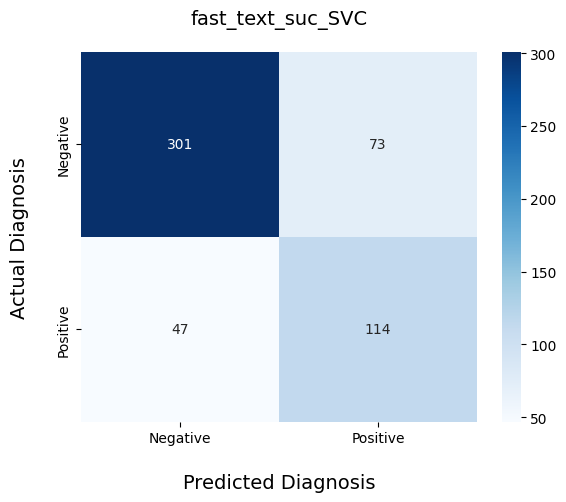

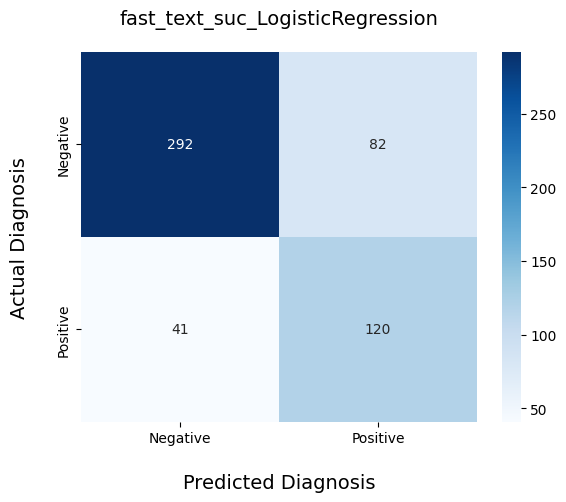

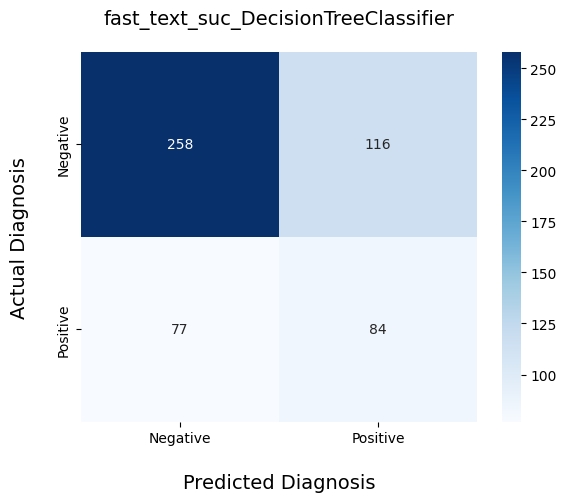

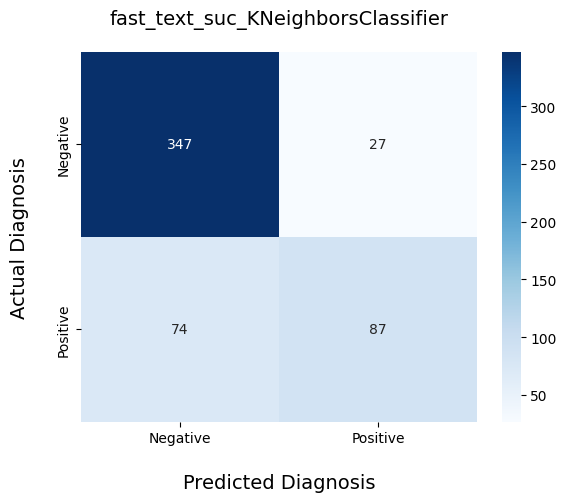

In [94]:
frames = []

for name, model in task_1_fast_text_suc_models.items():
    y_pred = model["estimator"].predict(X_test)

    frames.append(
        {
            "name": name,
            "accuracy": metrics.accuracy_score(y_test, y_pred),
            "precision": metrics.precision_score(y_test, y_pred),
            "recall": metrics.recall_score(y_test, y_pred),
            "f1": metrics.f1_score(y_test, y_pred),
            "roc_auc": metrics.roc_auc_score(y_test, y_pred),
        }
    )

    ax = sns.heatmap(
        metrics.confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues"
    )

    ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(["Negative", "Positive"])

    ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(["Negative", "Positive"])

    ax.set_title(name, fontsize=14, pad=20)

    plt.show()

metrics_df = pd.DataFrame(frames)

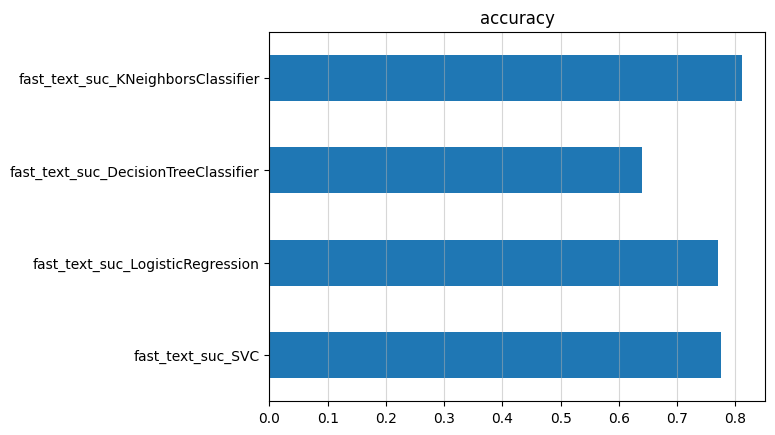

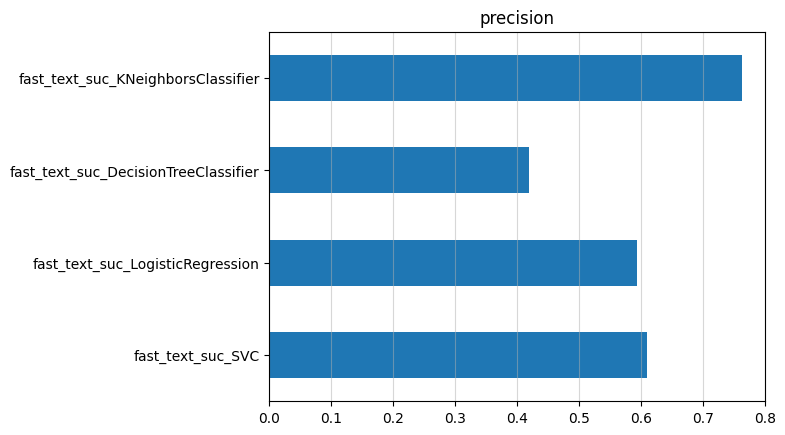

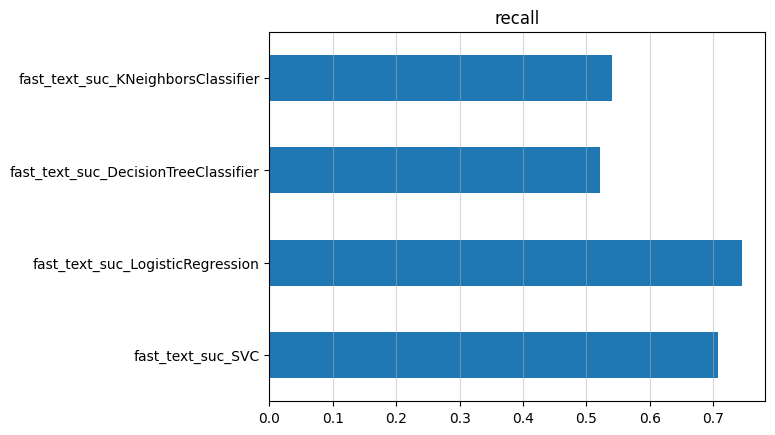

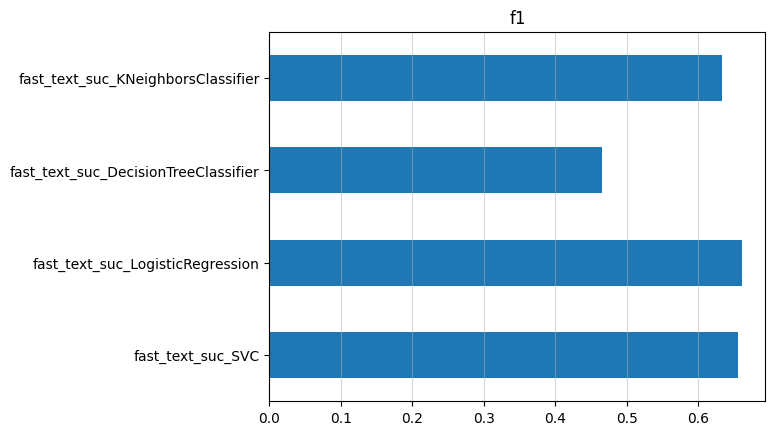

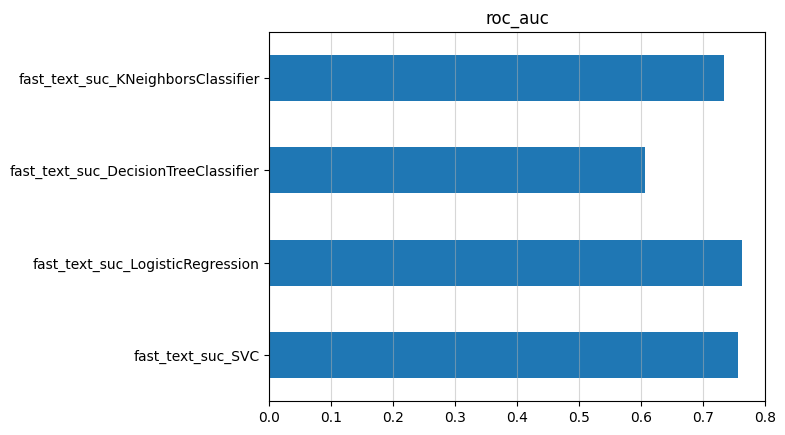

In [95]:
metrics_df = metrics_df.set_index("name")

for col in metrics_df.columns:
    metrics_df[col].plot(kind="barh")
    plt.title(col)
    plt.grid(axis="x", alpha=0.5)
    plt.ylabel("")
    plt.show()


In [96]:
display(metrics_df)

,accuracy,precision,recall,f1,roc_auc
name,,,,,
fast_text_suc_SVC,0.775701,0.609626,0.708075,0.655172,0.756444
fast_text_suc_LogisticRegression,0.770093,0.594059,0.745342,0.661157,0.763045
fast_text_suc_DecisionTreeClassifier,0.639252,0.420000,0.521739,0.465374,0.605789
fast_text_suc_KNeighborsClassifier,0.811215,0.763158,0.540373,0.632727,0.734090


We can see that the highest accuracy was obtained by KNeighborsClassifier. However, we should keep in mind that the accuracy is not the best metric for imbalanced data. If we look at the confusion matrix for KNN it is clear that the model tends to predict tweets as non-humorous (majority class) and has a hard time to correctly classify texts containing humour.

When it comes to F1 score, the best performing model was surprisingly LogisticRegression, however the performance is not satisfactory. In future we will consider tweaking current way of feature extraction, try other representations and different ML models in order to improve the results.


# Subtask 2b: Degree of Prejudice Prediction

In [28]:
CURRENT_TASK = TASK.TWO_B

For now we decided to train models on fasttext embeddings, but we will try other embeddings in the future.


In [29]:
X, y = get_X_y(fast_text_suc_df, "mean")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RS
)

As the prediction models we have chosen the following:

1. SVC

TODO: Try other models


In [30]:
task_2b_fast_text_suc_models = {}

## SVR

SVR is a regression model that uses a kernel to map the data into a higher dimensional space in order to find a linear regression function in that space.

Hyperparameters we decided to tune:
- `C`: Inverse regularization parameter. Described in the SVC section of the notebook.
  - _positive numbers_ `{0.1, 1 (default), 10, 100}`
- `kernel`: Described int the SVC section of the notebook.
  - `linear`
  - `poly`
  - `rbf` (default)
  - `sigmoid`
- `degree`: Degree of the polynomial kernel function. Ignored by all other kernels. This parameter is only considered in case of `poly` kernel.
  - _positive integers_ `{2, 3 (default), 4, 5, 6}`
  

In [34]:
NAME = "fast_text_suc_SVR"

task_2b_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2b_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": [2, 3, 4, 5, 6],
    }

    task_2b_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=SVR(),
            param_grid=param_grid,
            X=X_train,
            y=y_train,
            scoring="neg_root_mean_squared_error",
        )
    }

    save_model(NAME, CURRENT_TASK, task_2b_fast_text_suc_models[NAME])

Loaded task_2b/fast_text_suc_SVR model from file
Hyperparameters:


{'C': 1, 'degree': 2, 'kernel': 'rbf'}

Best score: -0.7198 neg_root_mean_squared_error


## GradientBoostingRegressor

In [41]:
NAME = "fast_text_suc_GradientBoostingRegressor"

from sklearn.ensemble import GradientBoostingRegressor


task_2b_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2b_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "loss" : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        "learning_rate" : [0.0, 0.1, 0.3, 0.6],
        "criterion": ["friedman_mse", "squared_error"],
        "max_depth": [1, 3, 6],
        # "max_features": [None, 0.2, 0.4, 0.6, 0.8, 'auto', 'sqrt', 'log2' ],
        # "min_samples_leaf": [1, 2, 4, 8],
        # "min_samples_split": [2, 4, 8],
        # "min_weight_fraction_leaf" : [0.0, 0.2, 0.4],
    }

    task_2b_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=GradientBoostingRegressor(),
            param_grid=param_grid,
            X=X_train,
            y=y_train,
            scoring="neg_root_mean_squared_error",
        )
    }

    save_model(NAME, CURRENT_TASK, task_2b_fast_text_suc_models[NAME])

No task_2b/fast_text_suc_GradientBoostingRegressor model found
Training task_2b/fast_text_suc_GradientBoostingRegressor model
Hyperparameters found:


{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3}

Best score: -0.7299 neg_root_mean_squared_error
Saving task_2b/fast_text_suc_GradientBoostingRegressor model to file


## ElasticNet



In [43]:
NAME = "fast_text_suc_ElasticNet"

task_2b_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

from sklearn.linear_model import ElasticNet

if task_2b_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "alpha": [0.0, 0.5, 1.0, 5.0],
        "max_iter": [200, 500, 1000, 2000],
        "selection": ['cyclic', 'random'],
        "l1_ratio" : [0.0, 0.5, 1.0],
        "random_state" : [None, 0, 42],

    }

    task_2b_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=ElasticNet(),
            param_grid=param_grid,
            X=X_train,
            y=y_train,
            scoring="neg_root_mean_squared_error",
        )
    }

    save_model(NAME, CURRENT_TASK, task_2b_fast_text_suc_models[NAME])

No task_2b/fast_text_suc_ElasticNet model found
Training task_2b/fast_text_suc_ElasticNet model
Hyperparameters found:


c:\Users\sarae\Desktop\LNR\LNR-project\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.850e+02, tolerance: 1.377e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5,
 'l1_ratio': 0.0,
 'max_iter': 200,
 'random_state': None,
 'selection': 'cyclic'}

Best score: -0.7991 neg_root_mean_squared_error
Saving task_2b/fast_text_suc_ElasticNet model to file


## SGDRegressor


In [44]:
NAME = "fast_text_suc_SGDRegressor"

task_2b_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

from sklearn.linear_model import SGDRegressor

if task_2b_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "loss" : ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive' ],
        "penalty" : ['l2', 'l1', 'elasticnet', None],
        "max_iter": [500, 1000, 2000],
        "learning_rate": ['constant', 'optimal', 'invscaling', 'adaptive'],
    }

    task_2b_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=SGDRegressor(),
            param_grid=param_grid,
            X=X_train,
            y=y_train,
            scoring="neg_root_mean_squared_error",
        )
    }

    save_model(NAME, CURRENT_TASK, task_2b_fast_text_suc_models[NAME])

No task_2b/fast_text_suc_SGDRegressor model found
Training task_2b/fast_text_suc_SGDRegressor model
Hyperparameters found:


{'learning_rate': 'adaptive',
 'loss': 'squared_error',
 'max_iter': 500,
 'penalty': 'l1'}

Best score: -0.7489 neg_root_mean_squared_error
Saving task_2b/fast_text_suc_SGDRegressor model to file


## Results

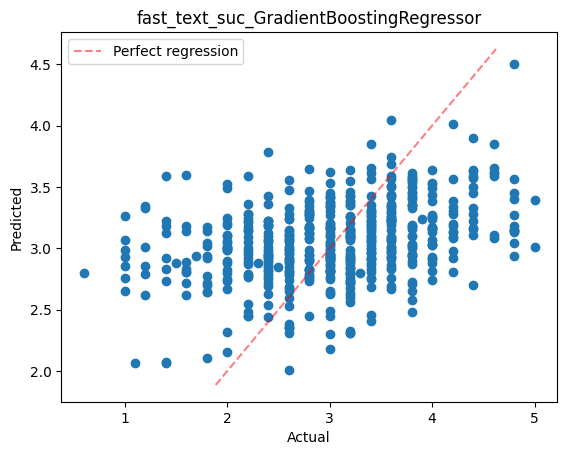

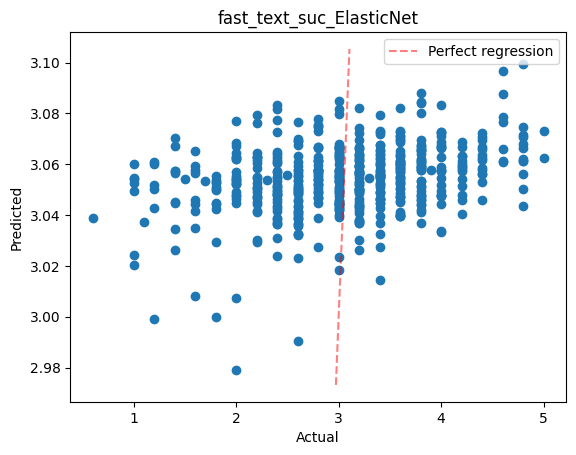

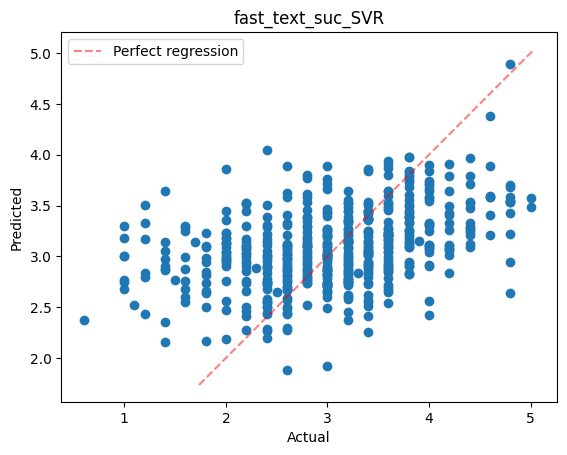

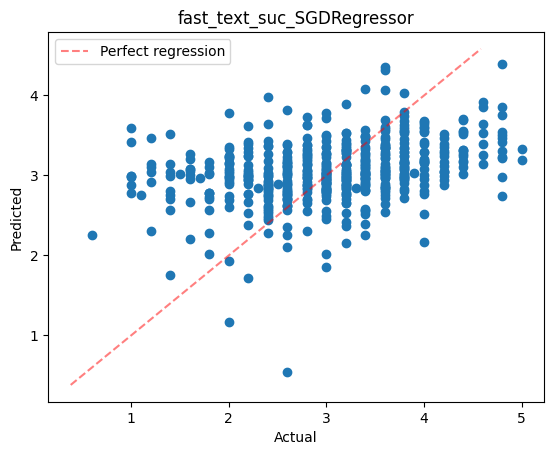

In [45]:
frames = []

for name, model in task_2b_fast_text_suc_models.items():
    y_pred = model["estimator"].predict(X_test)

    frames.append(
        {
            "name": name,
            "r2": metrics.r2_score(y_test, y_pred),
            "rmse": metrics.mean_squared_error(y_test, y_pred, squared=False),
        }
    )

    plt.scatter(y_test, y_pred)
    plt.title(name)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    min_lim = max(x_min, y_min)
    max_lim = min(x_max, y_max)
    plt.plot([min_lim, max_lim], [min_lim, max_lim], ls="--", alpha=0.5, color="red", label="Perfect regression")
    plt.legend()
    plt.show()

metrics_df = pd.DataFrame(frames)

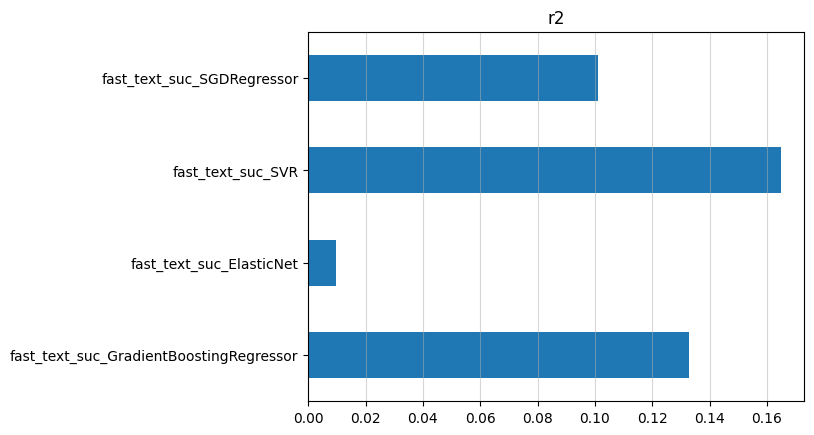

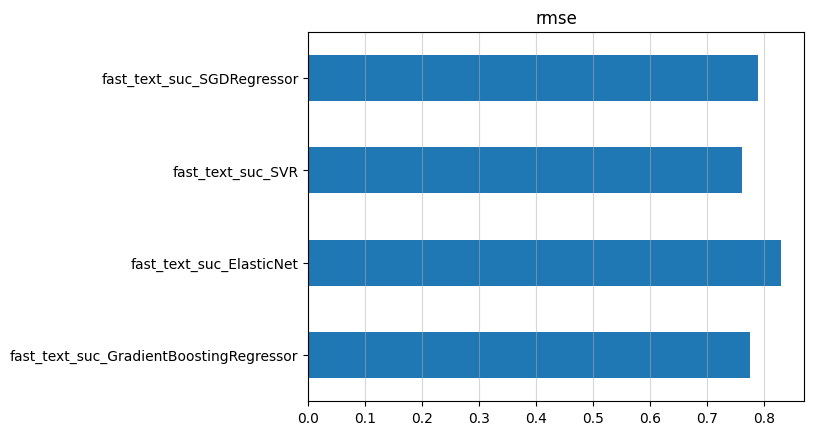

In [46]:
metrics_df = metrics_df.set_index("name")

for col in metrics_df.columns:
    metrics_df[col].plot(kind="barh")
    plt.title(col)
    plt.grid(axis="x", alpha=0.5)
    plt.ylabel("")
    plt.show()

It doesn't look like the model is learning much. We will try other models and embeddings in the future.